In [1]:
import pickle

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
data = pickle.load(open("/home/laclavere/Thesis/qubic/qubic/scripts/MapMaking/src/FMM/planck/maps/old_None.pkl", "rb"))

In [3]:
data.keys()

dict_keys(['maps_in', 'maps_in_convolved', 'maps', 'maps_noise', 'tod', 'nus', 'coverage', 'convergence', 'center', 'parameters', 'fwhm_in', 'fwhm_out', 'fwhm_rec', 'seenpix', 'duration', 'qubic_dict'])

In [4]:
fwhm_in = data["fwhm_in"]
fwhm_out = data["fwhm_out"]
fwhm_rec = data["fwhm_rec"]
# fwhm_rec[0] = 0.0061
# fwhm_rec[1] = 0.0041

nus = data["nus"]
Nrec = nus.shape[0] - 7

maps_input = data["maps_in_convolved"]
# for irec in range(Nrec):
#     C = HealpixConvolutionGaussianOperator(fwhm_rec[irec])
#     maps_input[irec] = C(maps_input[irec])
maps_rec = data["maps"][:Nrec]
maps_res = maps_input - maps_rec
center = data["center"]
seenpix = data["seenpix"]
convergence = data["convergence"]

In [5]:
print(Nrec)
print(nus.shape)
print(maps_input.shape)

2
(9,)
(2, 196608, 3)


In [6]:
print("FWHM in: ", fwhm_in)
print("mean fwhm in: ", np.mean(fwhm_in))
print("FWHM out: ", fwhm_out)
print("FWHM rec: ", fwhm_rec)

FWHM in:  [0. 0. 0. 0. 0. 0. 0. 0.]
mean fwhm in:  0.0
FWHM out:  [0. 0. 0. 0. 0. 0. 0. 0.]
FWHM rec:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]


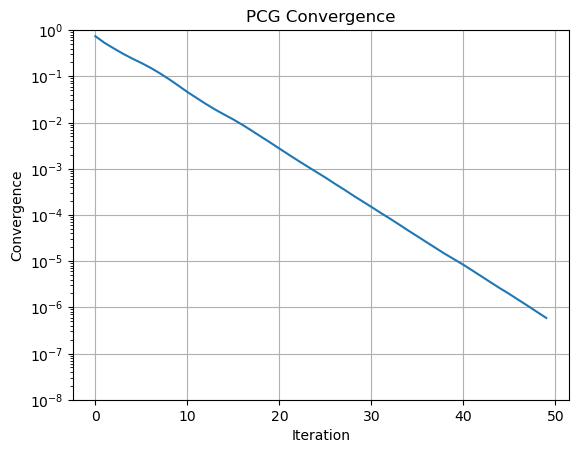

In [7]:
plt.plot(convergence)
plt.xlabel("Iteration")
plt.ylabel("Convergence")
plt.title("PCG Convergence")
plt.yscale("log")
plt.ylim(1e-8, 1e0)
plt.grid()
plt.show()

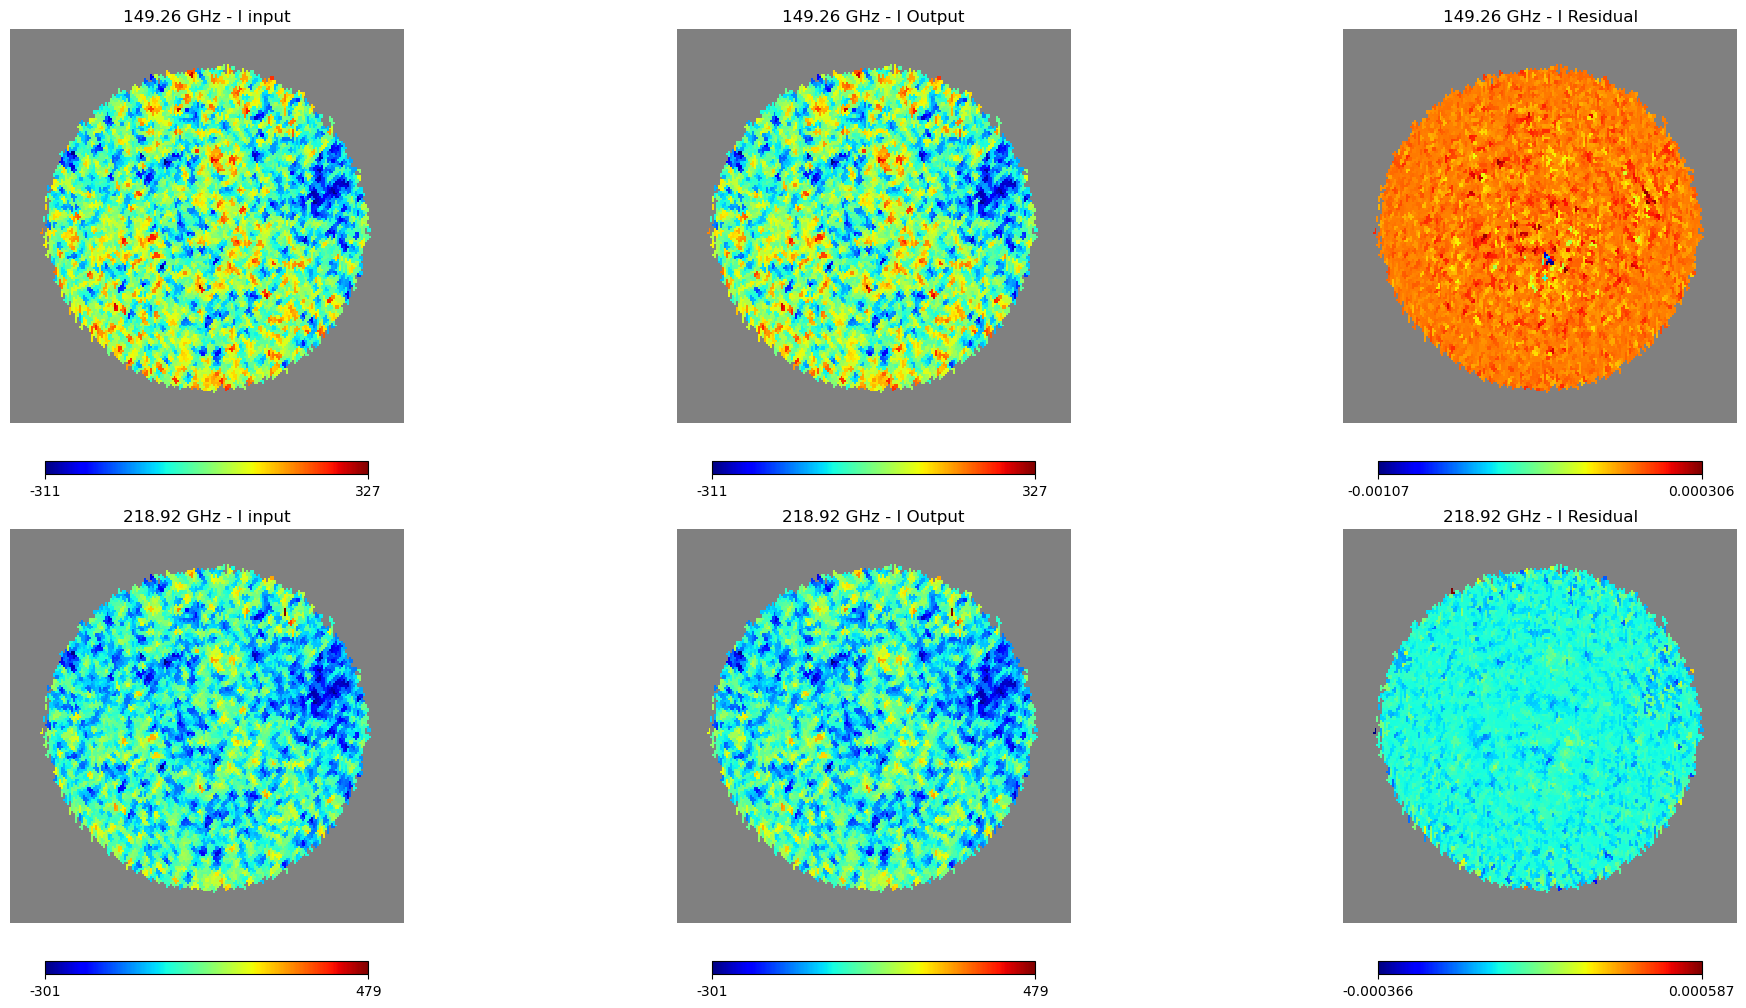

In [8]:
STOKES = ["I", "Q", "U"]

maps_input[:, ~seenpix, :] = hp.UNSEEN
maps_rec[:, ~seenpix, :] = hp.UNSEEN
maps_res[:, ~seenpix, :] = hp.UNSEEN

istk = 0
n = 2
# sigma_input = np.std(maps_input[:, seenpix, istk], axis=0)
# sigma_rec = np.std(maps_rec[:, seenpix, istk], axis=0)
# sigma_res = np.std(maps_rec[:, seenpix, istk] - maps_input[:, seenpix, istk], axis=0)

reso = 15

k = 0

plt.figure(figsize=(20, 10))
for inu in range(Nrec):
    hp.gnomview((maps_input[inu, :, istk]), rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} input",  
                        cmap="jet",
                        # min = - n * sigma_input[inu],
                        # max = n * sigma_input[inu],
                        sub=(Nrec, 3, k + 1))
    
    hp.gnomview((maps_rec[inu, :, istk]), rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} Output",
                        cmap="jet",
                        # min = - n * sigma_rec[inu],
                        # max = n * sigma_rec[inu],
                        sub=(Nrec, 3, k + 2))
    
    hp.gnomview(maps_res[inu, :, istk], rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} Residual",
                        cmap="jet",
                        # min = - n * sigma_res[inu],
                        # max = n * sigma_res[inu],
                        sub=(Nrec, 3, k + 3))
    k += 3

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
icomp = 0

test_in = data["maps_in"][icomp].copy()
test_out = data["maps"][icomp].copy()

test_in[~seenpix, :] = 0
test_out[~seenpix, :] = 0

In [ ]:
def chi2_fwhm(fwhm):
    if fwhm < 0 or fwhm > 0.1:
        return np.inf
    else:
        C = HealpixConvolutionGaussianOperator(fwhm)
        input_maps = C(test_in)
            
        return np.sum((test_out - input_maps) ** 2) / np.sum(input_maps ** 2)

In [ ]:
list_chi2 = []

fwhm = np.logspace(np.log10(0.0005), np.log10(0.05), num=80)
for i in fwhm:
    list_chi2.append(chi2_fwhm(i))

list_chi2 = np.array(list_chi2)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(fwhm, list_chi2)
plt.vlines(fwhm[np.where(list_chi2 == np.min(list_chi2))[0][0]], 0, 2, color="red", linestyle="--", label=f"Best fit : {fwhm[np.where(list_chi2 == np.min(list_chi2))[0][0]].round(4)}")
plt.vlines(fwhm_rec[icomp], 0, 2, color="green", linestyle="--", label=f"FWHM rec : {fwhm_rec[icomp].round(4)}")
plt.title("Chi2 as a function of fwhm")
plt.xlabel("FWHM")
plt.ylabel("Chi2")
plt.grid()
plt.legend()
plt.show()